# load imports

In [27]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import warnings 
def action_with_warnings():
    warnings.warn("ignore")
with warnings.catch_warnings(record=True):    
    from pathlib import Path
    import os
    import pandas as pd
    from tiffile import imread, imwrite
    import glob
    import caiman as cm
    
from datetime import datetime as dt, timedelta
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

from tqdm.auto import tqdm
import numpy as np

import scipy

from PIL import Image
import xml.etree.ElementTree as et

In [49]:
%autoreload 
import sys
sys.path.append(r'C:\Users\NaumannLab_KEF\PyCharmProjects\imaging\caImageAnalysis')
import process, bruker_images, photostimulation
from utilities import arrutils, statutils, coordutils
from fishy import BaseFish, PhotostimFish, VizStimVolume

# setting up variables

In [31]:
photostim_data = Path(r'D:\Imaging_Bruker\20240115_singlecell_stim_habenula\Chrmine_fish2\testing_tyler_params_2-001')

omr_tseries_path = Path(r'D:\Imaging_Bruker\Whit\20240124_functional_to_stim_CoSyne\omr_stack_fish14-000')
label = 'right'

# preprocessing, if a single plane:

In [32]:
if not Path(photostim_data).joinpath('output_folders').exists():
    bruker_images.bruker_img_organization(photostim_data, testkey = 'ome', single_plane = True, pstim_file=False)

c:\Users\NaumannLab_KEF\mambaforge\envs\caiman2\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->time,key->block0_values] [items->Index(['time'], dtype='object')]

  encoding=encoding,
100%|██████████| 2/2 [00:14<00:00,  7.15s/it]


no pstim file
extra files copied to output folders


In [40]:
fld = Path(photostim_data).joinpath('output_folders/single_plane')

baseFish = BaseFish(folder_path = fld, frametimes_key = 'frametimes')
process.run_image_rotation(baseFish, angle = 90, crop = 0) #fixing image rotation, needs to happen before movement corr
process.run_movement_correction(baseFish, force = True)

baseFish = BaseFish(folder_path = fld, frametimes_key = 'frametimes') # refresh data_paths
photostimulation.save_badframes_arr(baseFish, no_planes = 1)
photostimulation.run_suite2p_PS(baseFish, move_corr = True)

found and loaded frametimes h5
saved bad frames array
{}
tif
** Found 1 tifs - converting to binary **
time 10.89 sec. Wrote 753 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: applying default C:\Users\NaumannLab_KEF\.suite2p\classifiers\classifier_user.npy
----------- REGISTRATION
Reference frame, 64.79 sec.
Registered 500/753 in 231.88s
Registered 753/753 in 351.85s
bad frames file path: D:\Imaging_Bruker\20240115_singlecell_stim_habenula\Chrmine_fish2\testing_tyler_params_2-001\output_folders\single_plane\bad_frames.npy
number of badframes: 14
----------- Total 440.12 sec
----------- REGISTRATION STEP 2
(making mean image (excluding bad frames)
registering two channels
Registered 500/753 in 233.03s
Registered 753/753 in 353.33s
Second channel, Registered 500/753 in 14.22s
Second channel, Registered 753/753 in 21.47s
bad frames file

making a PhotostimFish object for single plane

In [50]:
oneFish = PhotostimFish(folder_path = fld, 
                        no_planes = 1, 
                        stimmed_planes = [1],
                        rotate = True, 
                        frametimes_key = 'frametimes')

found and loaded frametimes h5


# preprocessing, if a volume:

In [ ]:
# run pre-processing if not done already

if not Path(photostim_data).joinpath('output_folders').exists():
    bruker_images.bruker_img_organization(photostim_data, testkey = 'ome', single_plane=False, pstim_file=False)

In [5]:
# to look at all the planes of the volume
paths = {}
with os.scandir(Path(photostim_data).joinpath('output_folders')) as entries:
    for entry in entries:
        if os.path.isdir(entry.path):
            paths[entry.name] = entry.path
number_of_planes = len(paths.keys())

# still pre_processing here:
for p in tqdm(paths.keys()):
    baseFish = BaseFish(folder_path = paths[p], frametimes_key = 'frametimes')
    process.run_image_rotation(baseFish, angle = 90, crop = 0) #fixing image rotation, needs to happen before movement corr
    process.run_movement_correction(baseFish, force = True)
    
    baseFish = BaseFish(folder_path = paths[p], frametimes_key = 'frametimes') # refresh data_paths
    photostimulation.save_badframes_arr(baseFish, no_planes = number_of_planes)
    photostimulation.run_suite2p_PS(baseFish, move_corr = True)

make a fish volume object for the photostim data

In [ ]:
# to gather all the planes of the volume
paths = {}
with os.scandir(Path(photostim_data).joinpath('output_folders')) as entries:
    for entry in entries:
        if os.path.isdir(entry.path):
            paths[entry.name] = entry.path
number_of_planes = len(paths.keys())

In [18]:
# make central vol processing class and identify stim sites, raw traces for stim sites
stimvolume = VizStimVolume()

# identify the planes that were stimulated from the OMR dataset that I have
the_stimmed_planes = photostimulation.identify_stimmed_planes(omr_tseries_path, label)

for p in tqdm(paths.keys()):  
    oneFish = PhotostimFish(folder_path = paths[p], 
                            no_planes = number_of_planes, 
                            stimmed_planes = the_stimmed_planes,
                            rotate = True, 
                            frametimes_key = 'frametimes')
    stimvolume.add_volume(oneFish)  # add them to volume    

  0%|          | 0/6 [00:00<?, ?it/s]

found and loaded frametimes h5
found and loaded frametimes h5
found and loaded frametimes h5
found and loaded frametimes h5
found and loaded frametimes h5
found and loaded frametimes h5


# ex 1) plot raw pixel traces for the stimulated sites in a volume

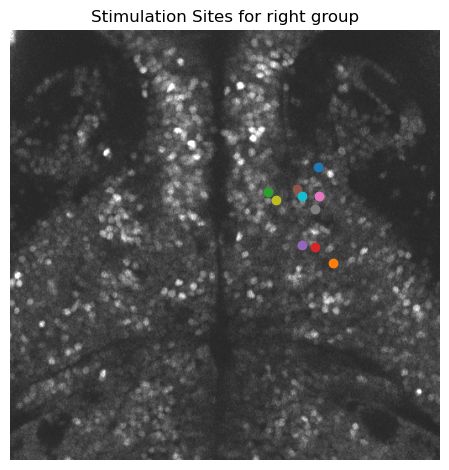

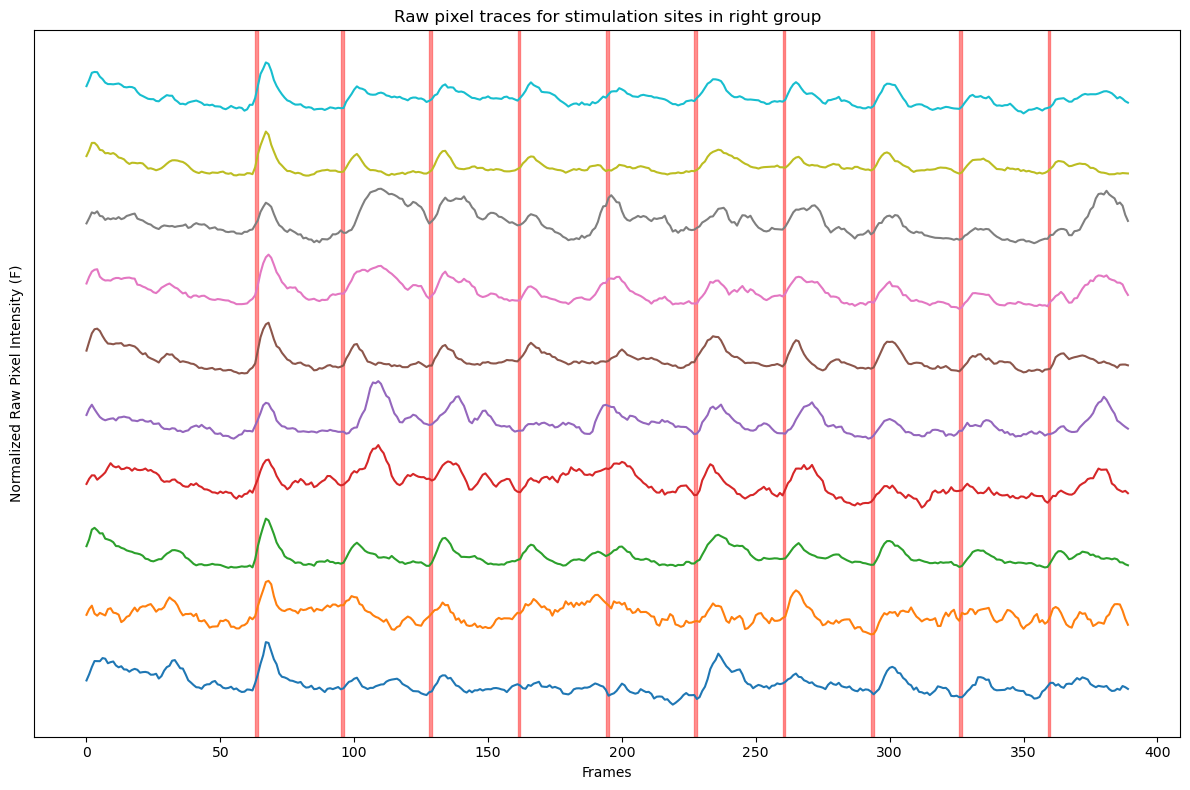

In [17]:
# for plotting only the stimulated sites
all_raw_traces = {}
all_points = {}
for x, y in stimvolume.volumes.items():
    raw_traces, points = photostimulation.collect_raw_traces(y)
    # plotting the ps events
    ps_events = np.load(Path(y.folder_path.joinpath('bad_frames.npy')))
    if x not in all_raw_traces.keys():
        all_raw_traces[x] = raw_traces
        all_points[x] = points

plt.imshow(stimvolume.volumes['plane_2'].ops['refImg'], cmap="gray", alpha=0.85, 
        vmax=np.percentile(stimvolume.volumes['plane_2'].ops['refImg'], 99.9))
for k in all_points.values():
    for l in k:
        plt.scatter(l[0], l[1])
plt.axis('off')
plt.title(f'Stimulation Sites for {label} group')
plt.tight_layout()
plt.show()

cell_list = []
for c in all_raw_traces.values():
    if len(c) != 0: # if not empty array
        norm_c = arrutils.norm_fdff(c)
        for cell in norm_c: # for each cell in c, make a cell array of stim cells
            cell_list.append(cell)

plt.figure(figsize=(12, 8))
for w, x in enumerate(cell_list):
    plt.plot(np.arange(len(x)), arrutils.pretty(x, 5)+ w)
for f in ps_events:
    plt.axvspan(xmin = f-3, xmax = f-2, color = 'red', alpha = 0.4)
plt.yticks([])
plt.ylabel('Normalized Raw Pixel Intensity (F)')
plt.xlabel('Frames')
plt.title(f'Raw pixel traces for stimulation sites in {label} group')
plt.tight_layout()
plt.show()  

# ex 2) finding correlation values between stimulation sites and cells in a volume

In [25]:
stim_traces_lst = []
for v in stimvolume:
    saved_raw_traces = Path(v.folder_path).joinpath('raw_traces.npy') 
    if np.load(saved_raw_traces).shape[0] != 0:
        stim_traces_lst.append(np.load(saved_raw_traces))

stim_traces_array = np.concatenate(stim_traces_lst, axis=0) # grab all raw traces together
sliced_stim_arrays = [x[stimvolume[0].baseline_frames:] for x in stim_traces_array] # only select after baseline time points
arrays = np.vstack(sliced_stim_arrays)

# calculate the correlation values between all 10 of the stimmed neurons
correlation_matrix = np.corrcoef(arrays) 
correlation_matrix[correlation_matrix == 1] = np.nan
 # this will be your divider (normalizing value) in the correlation df
divider = np.nanmean(correlation_matrix)

# running this full array of raw traces through the correlation analysis
for v in stimvolume:
    corr_df, corr_neurons = photostimulation.correlations_with_stim_sites(v, traces_array = stim_traces_array, 
                                                                        normalizing = divider, corr_threshold = 0.5)

c:\Users\NaumannLab_KEF\mambaforge\envs\caiman2\lib\site-packages\pandas\io\pytables.py:314: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)
c:\Users\NaumannLab_KEF\mambaforge\envs\caiman2\lib\site-packages\pandas\io\pytables.py:314: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  f(store)


saved correlation_df
saved correlation_df
saved correlation_df
saved correlation_df
saved correlation_df
saved correlation_df


# ex 3) plotting the heatmap of each trial of 1 normalized stimulation sites at a time

In [ ]:
big_corr_df_lst = []
raw_traces_arr_lst = []

for v in stimvolume:
    # get the correlation dfs
    corr_df = pd.read_hdf(Path(v.folder_path).joinpath('correlation_df.hdf'))
    corr_df['plane'] = v.data_paths['suite2p'].parents[1].name
    big_corr_df_lst.append(corr_df)

    # get the raw traces of each stimulation site
    raw_traces_arr = np.load(v.folder_path.joinpath('raw_traces.npy')) 
    raw_traces_arr_lst.append(raw_traces_arr)

big_corr_df = pd.concat(big_corr_df_lst)
stim_raw_traces = np.concatenate(raw_traces_arr_lst, axis = 0)
norm_stim_raw_traces = arrutils.norm_0to1(stim_raw_traces)

In [ ]:
offsets = [-7, 25]
frame_subset = arrutils.subsection_arrays(ps_events, offsets) # frame numbers for each event

for x, y in enumerate(norm_stim_raw_traces):
    # iterate through each photostimulation event, then grab the frames before and after each event
    each_trial = np.array([y[s] for s in frame_subset])

    # plot heatmap for each trial
    plt.figure(figsize=(10, 3))
    sns.heatmap(each_trial, cmap = 'viridis', vmin = 0, vmax = 1, xticklabels = 10)
    plt.axvspan(xmin = -offsets[0]-1, xmax = -offsets[0]-1, color = 'red', alpha = 0.8)
    plt.xlabel('Frames')
    plt.ylabel('Stimulation Events')
    plt.title(f'Example stimulation site #{x}')
    plt.show()

    # plot average trace for the cell
    data_mean = np.nanmean(each_trial, axis = 0)
    ci_lower, ci_upper = statutils.calculate_ci(each_trial)
    plt.figure(figsize=(8, 3))
    plt.plot(data_mean, color = 'k')
    plt.fill_between(range(len(data_mean)), ci_lower, ci_upper, color='skyblue', 
                     alpha=0.4, label='95% CI')  # Shade confidence interval
    plt.axvspan(xmin = -offsets[0]-1, xmax = -offsets[0], color = 'red', alpha = 0.4)
    plt.xlabel('Frames')
    plt.ylabel('Normalized Pixel Intensity')
    plt.ylim(0, 0.8)
    plt.title(f'Mean evoked dF/F for stimulation site #{x}')
    plt.show()

# ex 4) plotting single plane stimulation sites and image

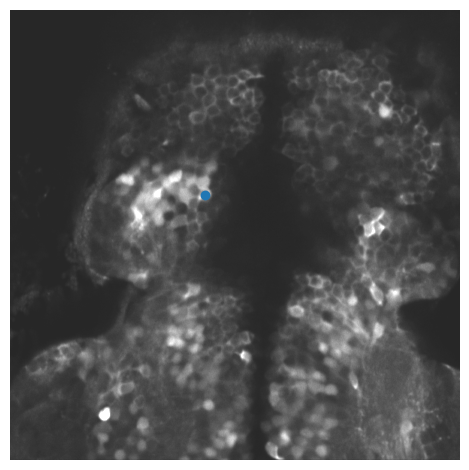

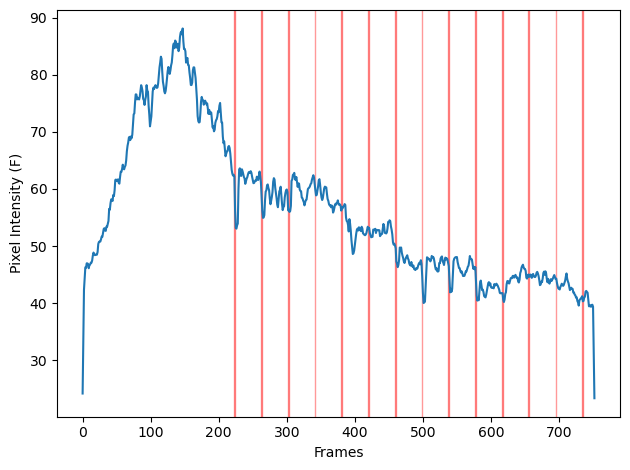

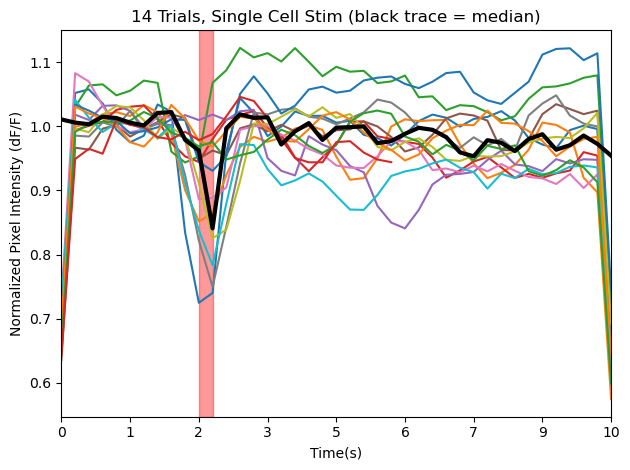

In [51]:
# plotting the locations
img = oneFish.ops["refImg"]
ps_events = oneFish.badframes_arr

plt.imshow(img, cmap="gray", alpha=0.85, vmax=np.percentile(img, 99.9))
for point in zip(oneFish.stim_sites_df.x_stim, oneFish.stim_sites_df.y_stim):
    plt.scatter(point[0], point[1])
plt.axis('off')
plt.tight_layout()
plt.show()

# plotting the raw traces with the baselines
for b, c in enumerate(oneFish.raw_traces):
    plt.plot(np.arange(len(oneFish.raw_traces[b])), arrutils.pretty(c, 5))
for f in ps_events:
    plt.axvspan(xmin = f-3, xmax = f-2, color = 'red', alpha = 0.4)
plt.xlabel('Frames')
plt.ylabel('Pixel Intensity (F)')

plt.tight_layout()
plt.show()

# plotting the averaged raw traces per stimulation
duration_in_frames = 1
pre = 10
post = 30
len_array = pre + post + duration_in_frames
array_per_trial = np.full((len(ps_events), len_array), np.nan)

for q, p in enumerate(ps_events):
    nested_trace = oneFish.raw_traces[:, p - pre : p + duration_in_frames + post]
    trace = [item for sublist in nested_trace for item in sublist]
    baseline_mean = np.nanmean(trace[5:pre])
    if p == ps_events[-1]:
        array_per_trial[q, :len(trace)] = trace/baseline_mean
    else:
        array_per_trial[q] = trace/baseline_mean

mean_trace = np.nanmedian(array_per_trial, axis=0)
std_trace = np.nanstd(array_per_trial, axis=0)
for a in array_per_trial:
    plt.plot(arrutils.pretty(a, 3))
plt.plot(mean_trace, color='k', linewidth=3)
plt.axvspan(xmin = pre, xmax = pre + duration_in_frames, color = 'red', alpha = 0.4)
plt.xlim(3, 38)
# plt.ylim(35, 75)
current_ticks = plt.xticks()[0]
current_labels = [float(label) for label in current_ticks]
new_labels = [int(c/oneFish.hzReturner(oneFish.frametimes_df)) for c in current_labels]
plt.xticks(current_ticks, new_labels)

plt.title('14 Trials, Single Cell Stim (black trace = median)')
plt.xlabel('Time(s)')
plt.ylabel('Normalized Pixel Intensity (dF/F)')

plt.tight_layout()
plt.show()